In [1]:
#import libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

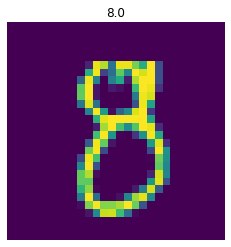

In [3]:
#prepare Dataset
#load data
train = pd.read_csv("train.csv", dtype = np.float32) # kaggle Digit Recognizer

#split data info features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 #normalization

#train test split. Size of train data is %80 and size of test data %20
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

#create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first 
#we create tensor,  then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

#create feature and targets tensor for test set
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

#batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

#pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest, targetsTest)

#data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

#visualize one of the images in data set
plt.imshow(features_numpy[421].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[421]))
plt.savefig("graph.png")
plt.show()

In [5]:
#create CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        #convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        #max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        
        #convolution 2
        self.cnn2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 1, padding = 0)
        self.relu2 = nn.ReLU()
        
        #max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        
        #fully connected 1
        self.fc1 = nn.Linear(32 * 4 * 4, 10)
        
    def forward(self, x):
        #convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        #max pool 1
        out = self.maxpool1(out)
        
        #convolution 2
        out = self.cnn2(out)
        out = self.relu2(out)
        
        #max pool 2
        out = self.maxpool2(out)
        
        #flatten
        out = out.view(out.size(0), -1)
        
        #linear function (readout)
        out = self.fc1(out)
        
        return out

    
#batch_size, epoch and iteration
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)
"""
#pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain, targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest, targetsTest)

#data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
"""
#create CNN
model = CNNModel()

#cross entropy loss
error = nn.CrossEntropyLoss()

#SGD optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)     

In [6]:
#cnn model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        #clear gradients
        optimizer.zero_grad()
        
        #forward propagation
        outputs = model(train)
        
        #calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        #calculating gradients
        loss.backward()
        
        #update parameters
        optimizer.step()
        count += 1
        if count % 50 == 0:
            #calculate accuracy
            correct = 0
            total = 0
            #iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(100,1,28,28))
                
                #forward propagation
                outputs = model(test)
                
                #get predictions from the maximum 
                predicted = torch.max(outputs.data, 1)[1]
                
                #total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
                
            accuracy = 100 * correct / float(total)
            
            #store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            #print loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))     

Iteration: 500  Loss: 0.09573162347078323  Accuracy: 96.41666412353516 %
Iteration: 1000  Loss: 0.04588596522808075  Accuracy: 97.5952377319336 %
Iteration: 1500  Loss: 0.039978619664907455  Accuracy: 97.71428680419922 %
Iteration: 2000  Loss: 0.01578962244093418  Accuracy: 98.25 %


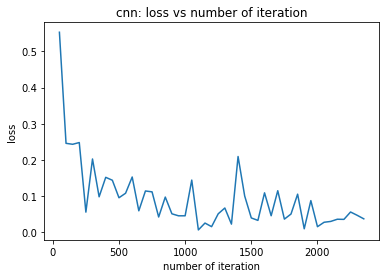

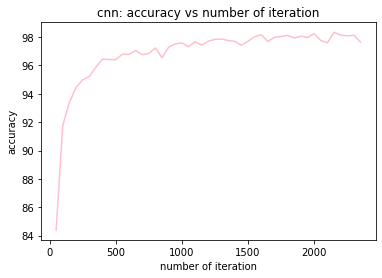

In [7]:
#visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("number of iteration")
plt.ylabel("loss")
plt.title("cnn: loss vs number of iteration")
plt.show()

#visualization accuracy
plt.plot(iteration_list,accuracy_list, color = "pink")
plt.xlabel("number of iteration")
plt.ylabel("accuracy")
plt.title("cnn: accuracy vs number of iteration")
plt.show()